In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv("../Data/Illustration Data/AAPL 1980 2022 fd 2.csv")
open_prices = df.fd_Open
dates = pd.to_datetime(df.Date, dayfirst= True)

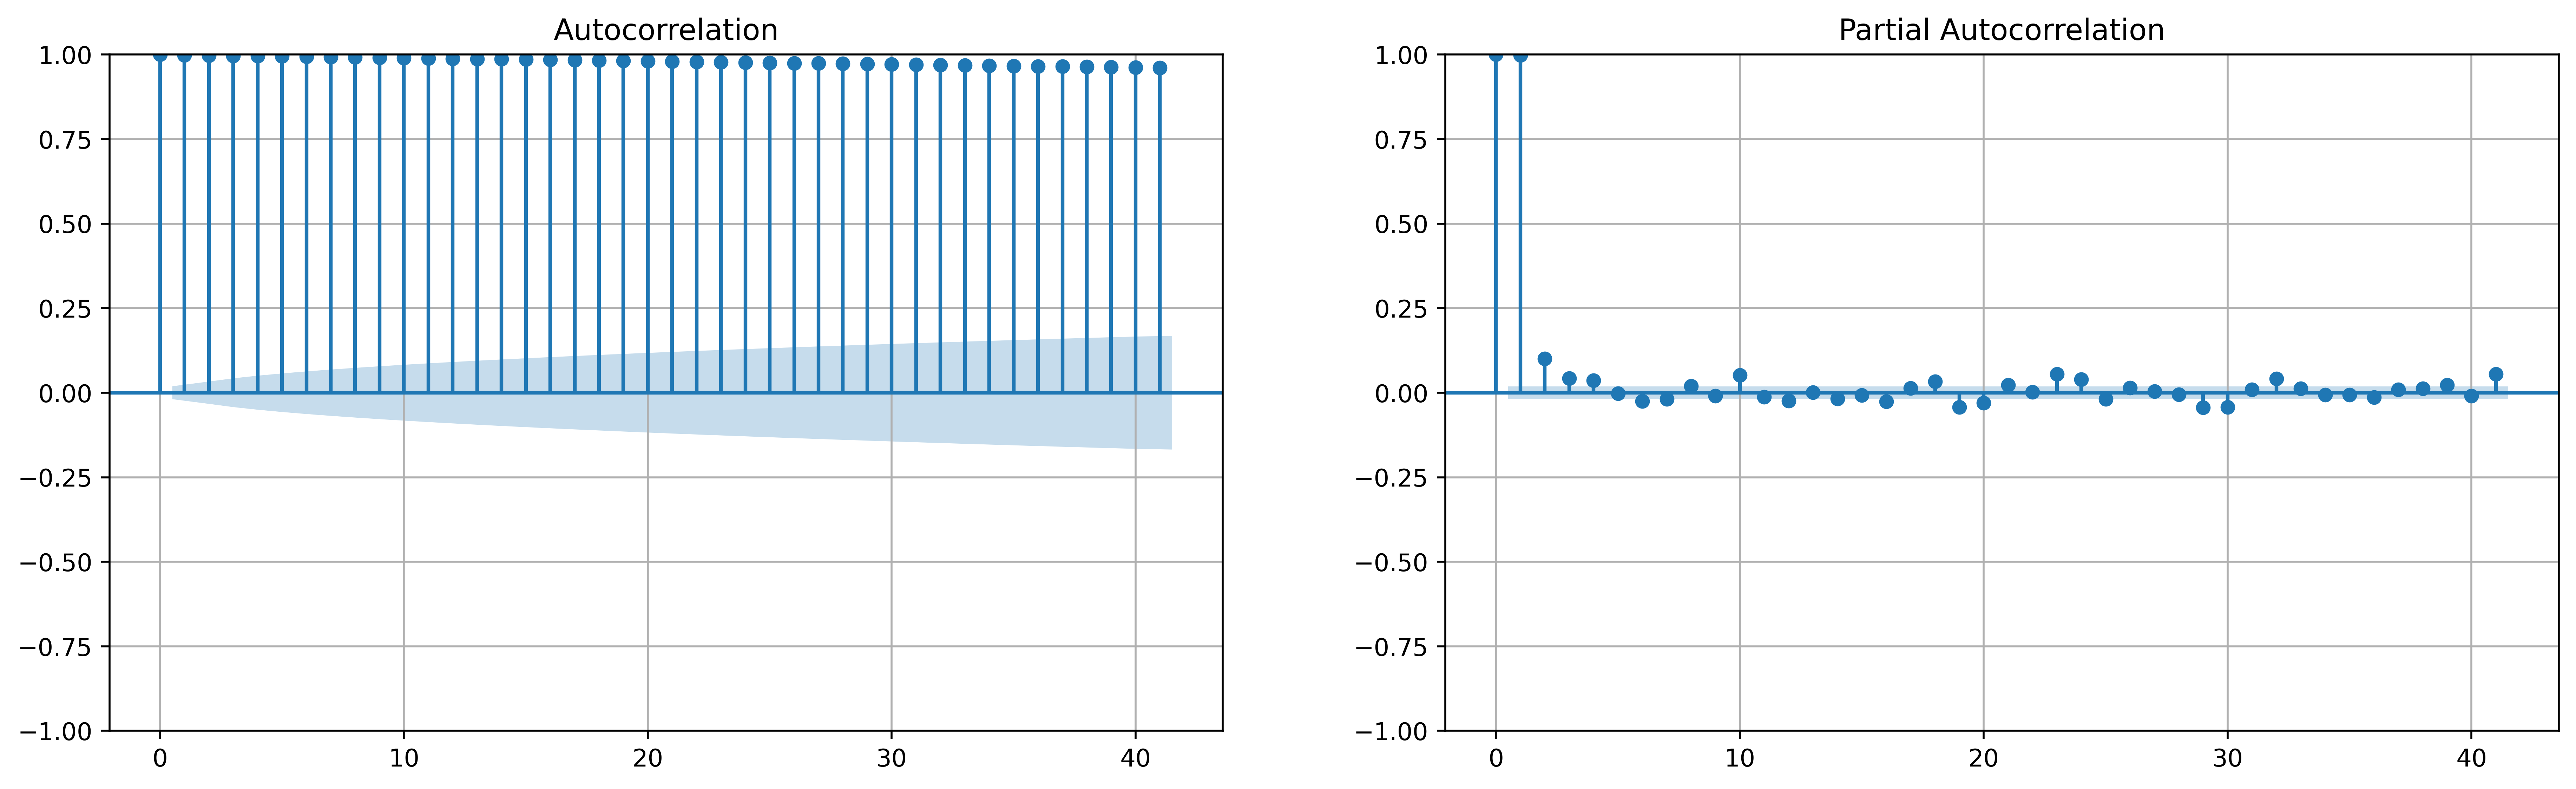

In [3]:
plt.rcParams.update({'figure.dpi' : 500})
f = plt.figure(figsize= (18, 5))

ax1 = f.add_subplot(121)
plot_acf(open_prices, ax= ax1);
plt.grid(True)

ax2 = f.add_subplot(122)
plot_pacf(open_prices, ax= ax2, method= "ywm");
plt.grid(True)

plt.show()

## Проверка стационарности

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="BIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [5]:
# тестирование ADF стационарности
adf_test(open_prices)

Results of Dickey-Fuller Test:
Test Statistic                     1.025594
p-value                            0.994529
#Lags Used                        26.000000
Number of Observations Used    10564.000000
Critical Value (1%)               -3.430969
Critical Value (5%)               -2.861814
Critical Value (10%)              -2.566916
dtype: float64


In [6]:
# тестирование KPSS стационарности
kpss_test(open_prices);

Results of KPSS Test:


/home/andrew/dev_env/std_env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic            7.866165
p-value                   0.010000
Lags Used                60.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [7]:
# переход к первым разностям
diff1_open_prices = open_prices.diff().dropna()

In [8]:
# тестирование ADF стационарности
adf_test(diff1_open_prices)

Results of Dickey-Fuller Test:
Test Statistic                   -20.978211
p-value                            0.000000
#Lags Used                        25.000000
Number of Observations Used    10564.000000
Critical Value (1%)               -3.430969
Critical Value (5%)               -2.861814
Critical Value (10%)              -2.566916
dtype: float64


In [9]:
# тестирование KPSS стационарности
kpss_test(diff1_open_prices);

Results of KPSS Test:
Test Statistic            0.461376
p-value                   0.050700
Lags Used                35.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## ACF и PACF

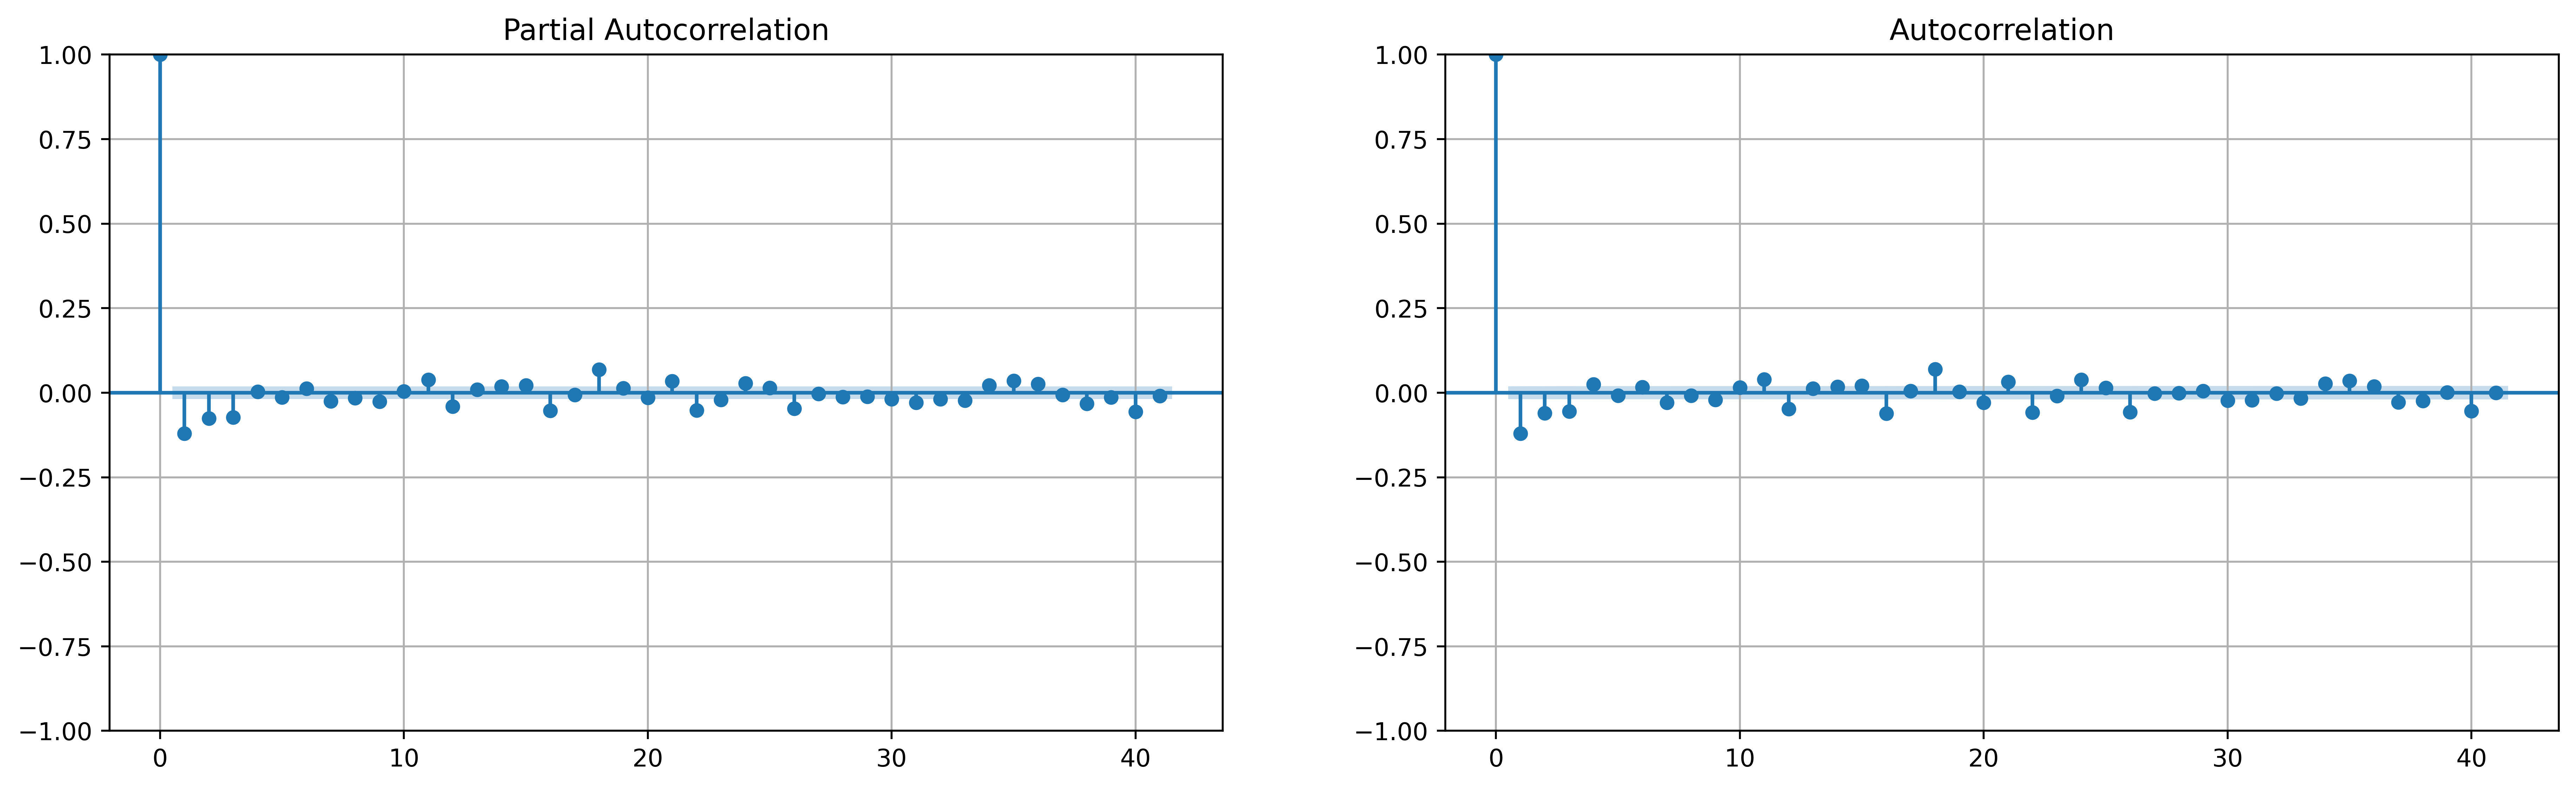

In [10]:
f = plt.figure(figsize= (18, 5))

ax1 = f.add_subplot(121)
plot_pacf(diff1_open_prices, ax= ax1, method= "ywm");
plt.grid(True)

ax2 = f.add_subplot(122)
plot_acf(diff1_open_prices, ax= ax2);
plt.grid(True)

plt.savefig("initial_acf_pacf.png", dpi=180)
plt.show()

# Оценка моделей

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
# ARIMA(0, 1, 0)
limit_size = -30

data_train = open_prices[:limit_size]
data_test = open_prices[limit_size:]

dates_train = dates[:limit_size]
dates_test = dates[limit_size:]

arima_model = ARIMA(data_train, order= (0, 1, 2))
model = arima_model.fit(cov_type= "robust")

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                fd_Open   No. Observations:                10561
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -12295.428
Date:                Sun, 26 Feb 2023   AIC                          24596.855
Time:                        20:29:29   BIC                          24618.650
Sample:                             0   HQIC                         24604.213
                              - 10561                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1439      0.044     -3.235      0.001      -0.231      -0.057
ma.L2         -0.0716      0.037     -1.923      0.054      -0.145       0.001
sigma2         0.6010      0.044     13.727      0.000       0.515       0.687
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):           1290551.85
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):           23355.43   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.12
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

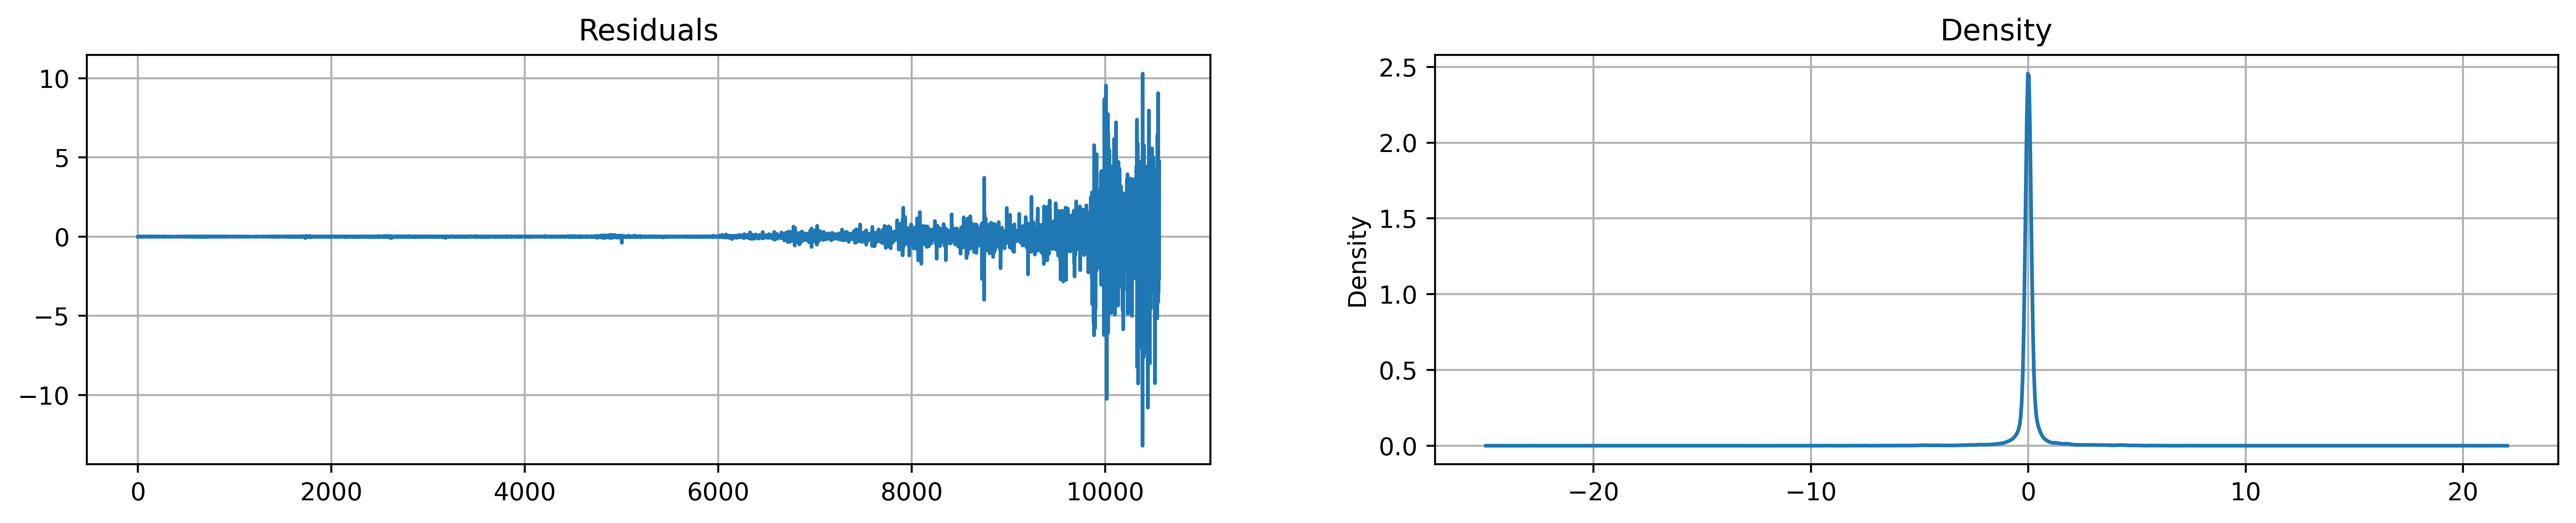

In [43]:
f = plt.figure(figsize= (18, 3))

residuals = model.resid[1:]

ax1 = f.add_subplot(121)
residuals.plot(title='Residuals', ax=ax1)
plt.grid(True)

ax2 = f.add_subplot(122)
residuals.plot(title='Density', kind='kde', ax=ax2)
plt.grid(True)
plt.savefig("residuals_and_density.png", dpi=180)
plt.show()

In [44]:
from statsmodels.stats.diagnostic import kstest_normal
# Из нормального распределения для alpha = 1%
kstest_normal(residuals.values)

(0.3191998772765163, 0.0009999999999998899)

In [45]:
from statsmodels.tsa.arima.model import ARIMAResults
# Из нормального распределения для alpha = 1%
# JB statistics, P-val, skew, kurtosis
ARIMAResults.test_normality(model, method= "jarquebera")

array([[ 1.29055185e+06,  0.00000000e+00, -9.74972286e-01,
         5.71227318e+01]])

In [46]:
print(f"Стандартное отклонение ошибок: {np.std(model.forecasts_error)}.")

Стандартное отклонение ошибок: 0.7751065833816713.


## Рисуем результат

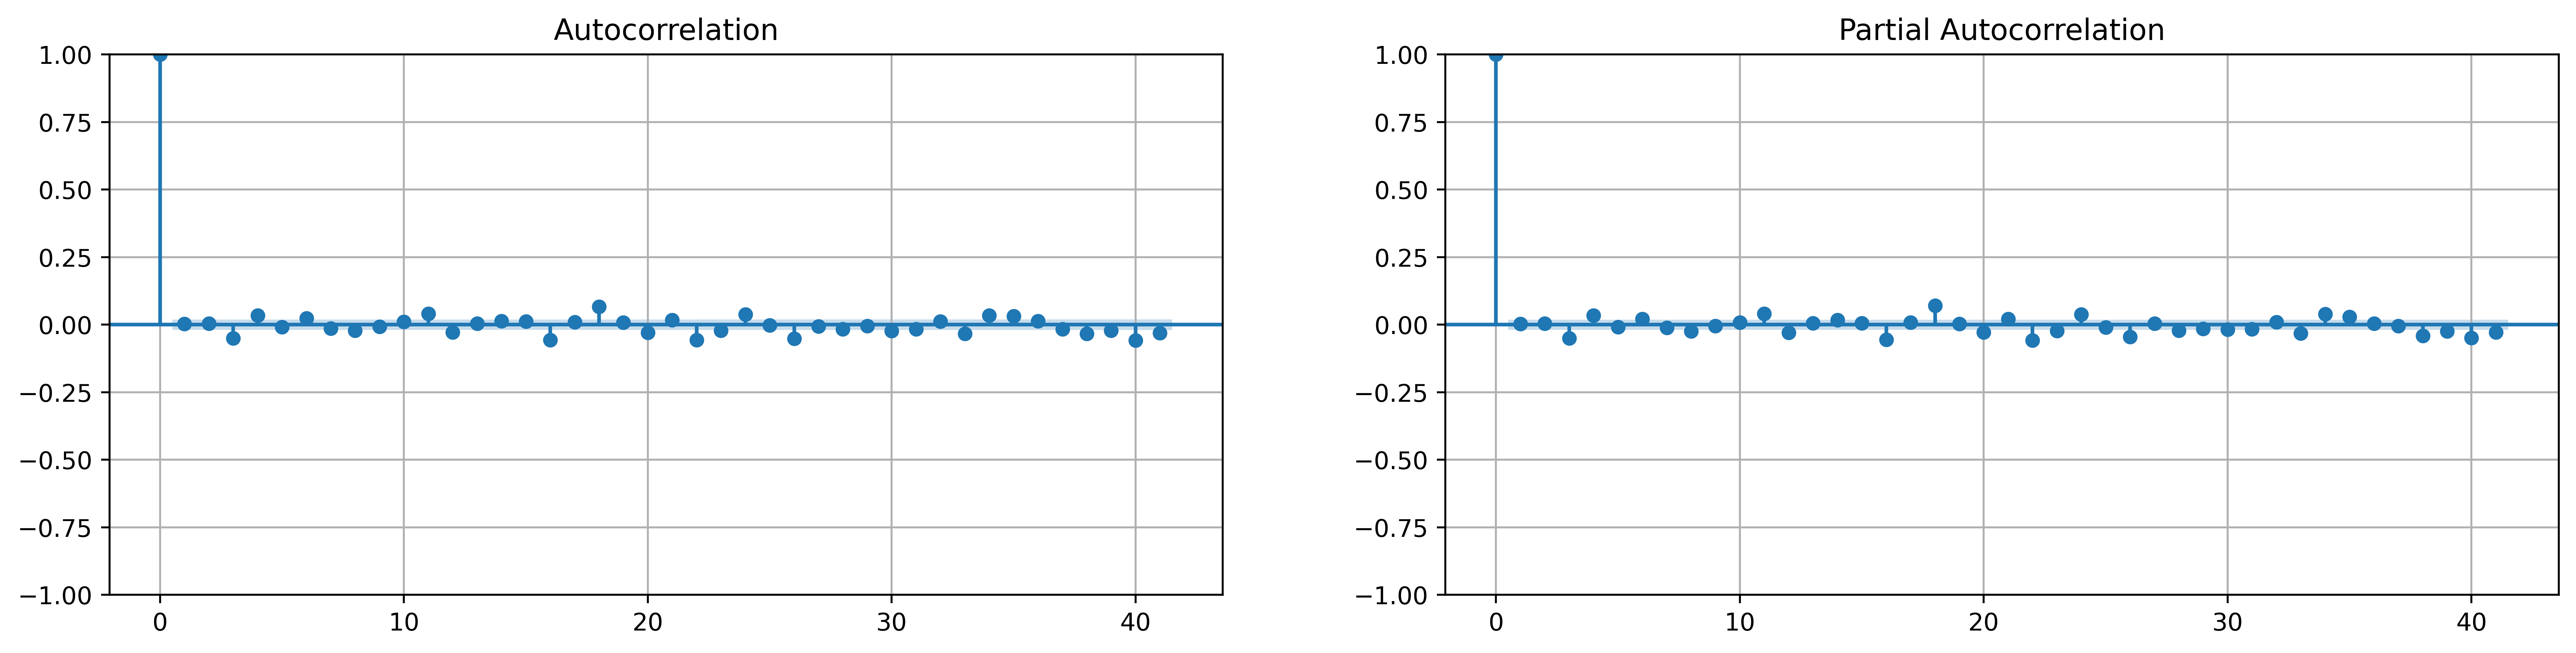

In [47]:
f = plt.figure(figsize= (18, 4))

ax1 = f.add_subplot(121)
plot_acf(residuals, ax= ax1);
plt.grid(True)

ax2 = f.add_subplot(122)
plot_pacf(residuals, ax= ax2, method= "ywm");
plt.grid(True)
plt.savefig("residuals_acf_pacf.png", dpi=180)
plt.show()

In [48]:
test_prediction = model.forecast(len(data_test))

In [49]:
from matplotlib.dates import DateFormatter

date_format = DateFormatter("%d/%m/%y")

confidence_interval = np.arange(1,31) * np.var(model.resid[1:])

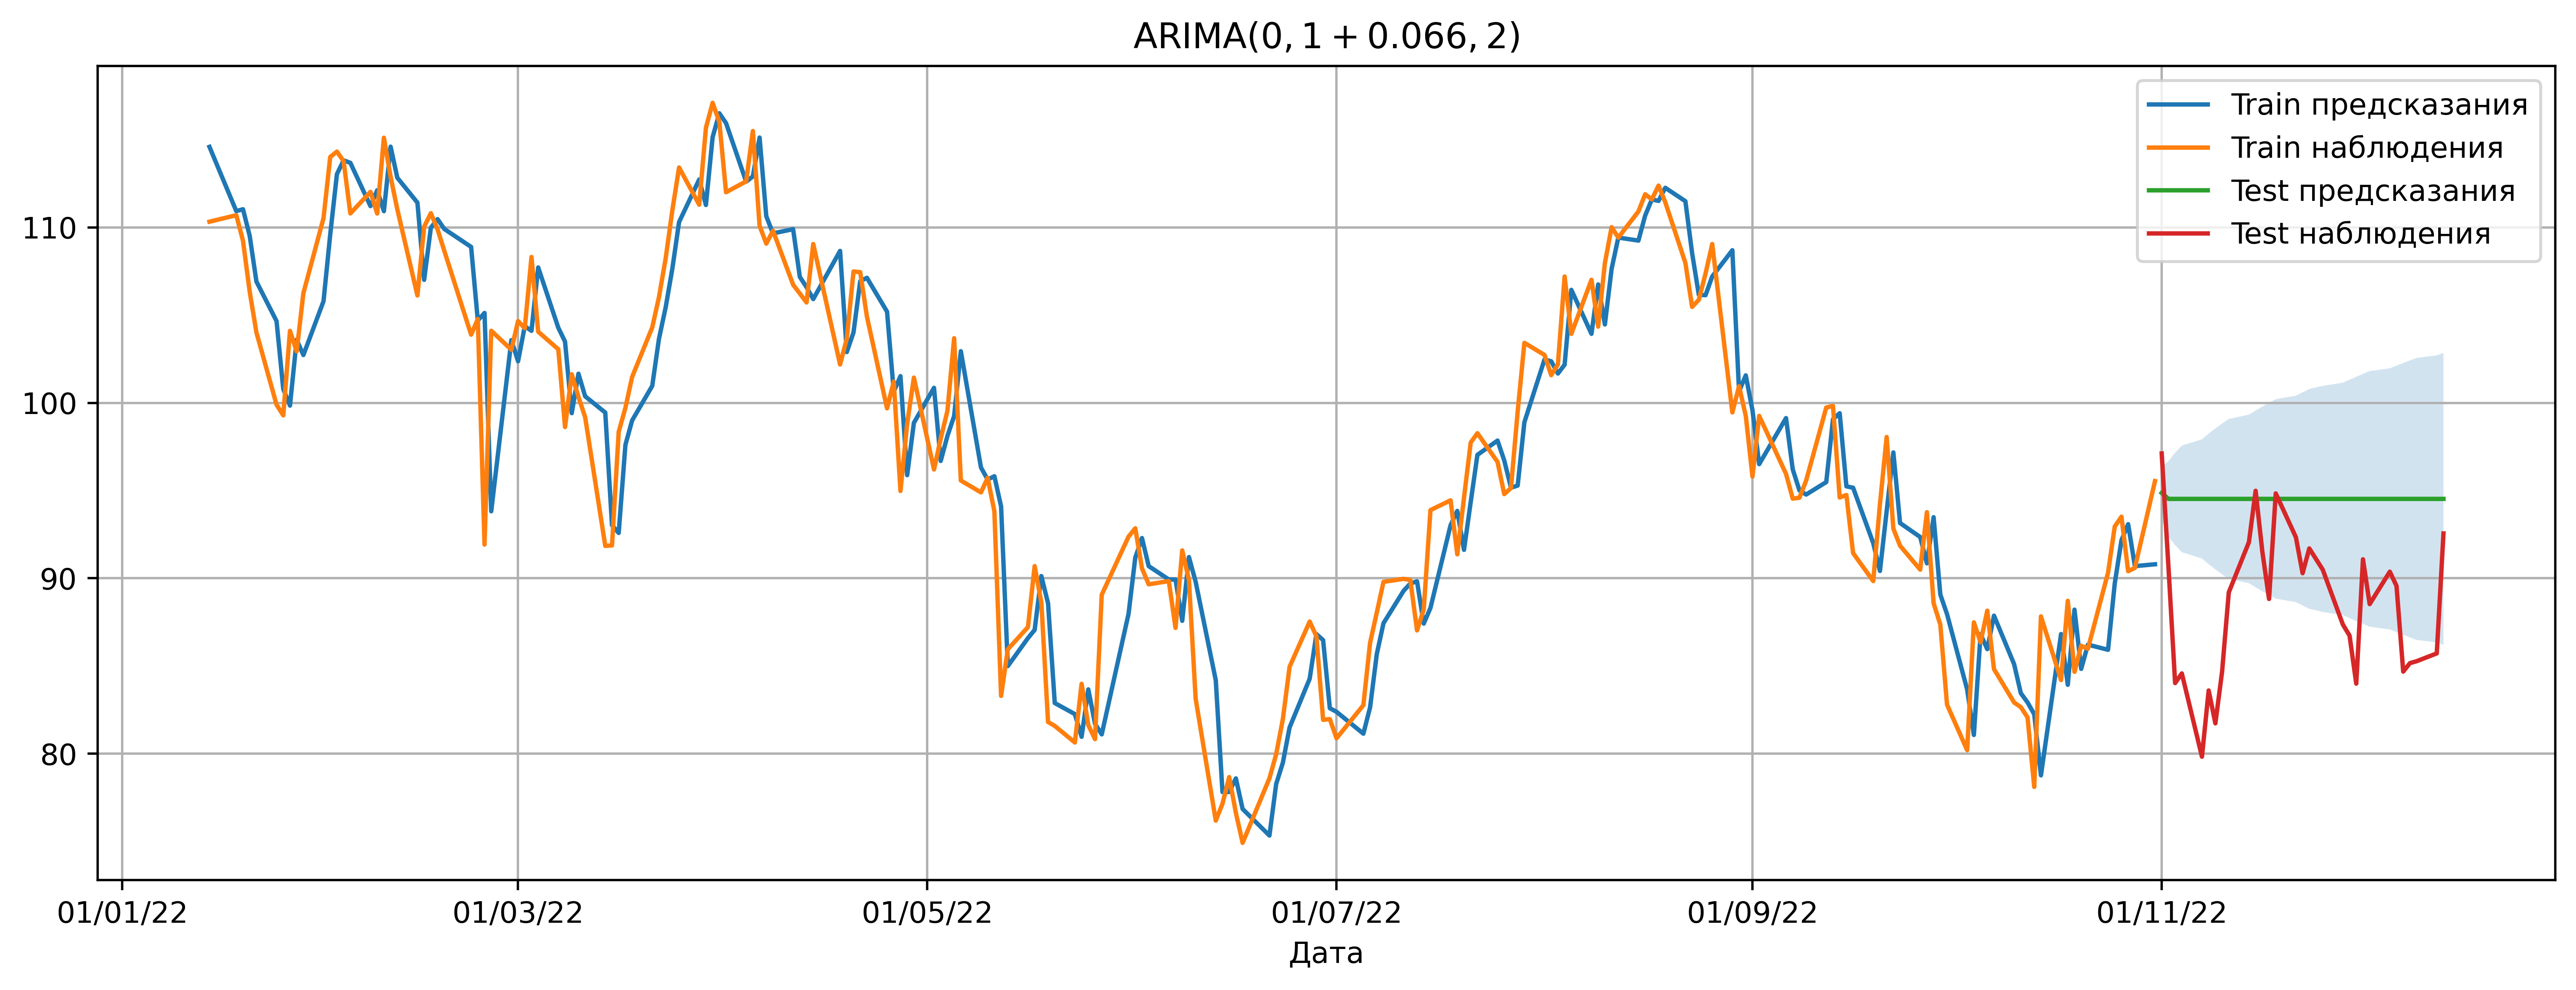

In [50]:
f, ax = plt.subplots(figsize= (15, 5))

start = -200
ax.set_title("ARIMA($0, 1 + 0.066, 2$)")
ax.set_xlabel("Дата")
ax.plot(dates_train[start:], model.fittedvalues[start:], label= "Train предсказания");
ax.plot(dates_train[start:], data_train[start:], label= "Train наблюдения");
ax.plot(dates_test, test_prediction, label= "Test предсказания");
ax.plot(dates_test, data_test, label= "Test наблюдения");
ax.fill_between(dates_test, test_prediction + 1.96 * np.sqrt(confidence_interval), test_prediction - 1.96 * np.sqrt(confidence_interval), alpha= 0.2);
ax.xaxis.set_major_formatter(date_format)
# ax.set_ylim(bottom= 110, top= 185)
plt.grid(True)

plt.legend(loc= "best")
plt.savefig("final_picture.png", dpi=180)
plt.show()